In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargamos todos los ficheros CSV para crear todos los DataFrames.
df_olist_customers = pd.read_csv('olist_customers_dataset.csv')
df_olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_olist_orders = pd.read_csv('olist_orders_dataset.csv')
df_olist_product_category_name = pd.read_csv('olist_product_category_name_translation.csv')
df_olist_products = pd.read_csv('olist_products_dataset.csv')
df_olist_sellers= pd.read_csv('olist_sellers_dataset.csv')

# Una vez creados y cargados los DataFrames comenzamos con el data cleaning elimando 
# valores duplicados.
df_olist_customers = df_olist_customers.drop_duplicates()
df_olist_order_items = df_olist_order_items.drop_duplicates()
df_olist_order_payments = df_olist_order_payments.drop_duplicates()
df_olist_order_reviews = df_olist_order_reviews.drop_duplicates()
df_olist_orders = df_olist_orders.drop_duplicates()
df_olist_product_category_name = df_olist_product_category_name.drop_duplicates()
df_olist_products = df_olist_products.drop_duplicates()
df_olist_sellers = df_olist_sellers.drop_duplicates()

In [3]:
# En el DataFrame que contiene las reviews de cada pedido comenzamos cambiando a tipo de dato DateTime los valores
# que contienen una fecha.
df_olist_order_reviews['review_creation_date'] = pd.to_datetime(df_olist_order_reviews['review_creation_date']) 
df_olist_order_reviews['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews['review_answer_timestamp']) 

# Creamos un raking para aquellas columnas del DataFrame de reviews que no contienen un titulo, para así establecer
# uno en función de la puntuación.
ranking = { 
    1: 'pesimo', 
    2: 'bajo', 
    3: 'bien', 
    4: 'recomendo', 
    5: 'super recomendo' 
} 

df_olist_order_reviews['review_comment_title'] = df_olist_order_reviews['review_comment_title'].fillna(df_olist_order_reviews['review_score'].map(ranking)) 
df_olist_order_reviews['review_comment_message'] = df_olist_order_reviews['review_comment_message'].fillna('No comment') 

# Rellenamos en el DataFrame de Productos los valores de 'product_category_name', con valor 'Unknown', y los valores nulos de 'product_name_lenght', 
# 'product_description_lenght', 'product_photos_qty' con la media del resto de valores.
df_olist_products['product_category_name'] = df_olist_products['product_category_name'].fillna('Unknown')
df_olist_products['product_name_lenght'] = df_olist_products['product_name_lenght'].fillna(df_olist_products['product_name_lenght'].mean())
df_olist_products['product_description_lenght'] = df_olist_products['product_description_lenght'].fillna(df_olist_products['product_description_lenght'].mean())
df_olist_products['product_photos_qty'] = df_olist_products['product_photos_qty'].fillna(df_olist_products['product_photos_qty'].mean())


#
categorias = df_olist_products['product_category_name'].unique() 

df_filtrado = df_olist_products[df_olist_products['product_category_name'].isin(categorias)] 

cols_numericas = df_olist_products.select_dtypes(include='float64').columns 

medias = df_filtrado[cols_numericas].median() 


df_filtrado[cols_numericas] = df_filtrado[cols_numericas].fillna(medias) 
df_olist_products.loc[df_olist_products['product_category_name'].isin(categorias), cols_numericas] = df_filtrado[cols_numericas] 

In [4]:
# Creamos el DataFrame de 'geolocation', primero obtenemos el 'zip_code_prefix', 'city', 'state' de los clientes y cambiamos el nombre de las
# columnas para poder concatenar con la 'geolocation' de sellers.
df_geolocation_customers = df_olist_customers[['customer_zip_code_prefix', 'customer_city', 'customer_state']].copy()
df_geolocation_customers.columns = ['zip_code_prefix', 'city', 'state']

# Creamos el DataFrame de 'geolocation' de sellers, primero obtenemos el 'zip_code_prefix', 'city', 'state' del DataFrame de Sellers y cambiamos el nombre
# de las columnas.
df_geolocation_sellers = df_olist_sellers[['seller_zip_code_prefix', 'seller_city', 'seller_state']].copy()
df_geolocation_sellers.columns = ['zip_code_prefix', 'city', 'state']

# Una vez tenemos los DataFrames de 'geolocation' los concatenamos para obtener el DataFrame de 'Olis_Geolocation'
df_olist_geolocation = pd.concat([df_geolocation_customers, df_geolocation_sellers]).drop_duplicates(subset=['zip_code_prefix'])

In [5]:
# Ahora preparamos el DataFrame de productos para establecer las categorias de los productos en inglés.
# Primero obtenemos todas las categorias distintas que tenemos en nuestro DataFrame de 'productos'.
categorias_productos = df_olist_products['product_category_name'].unique().tolist()
# Después obtenemos las diferentes categorias de las cuales tenemos la traducción.
categorias_productos_traducidos = df_olist_product_category_name['product_category_name'].unique().tolist()

# Una vez obtenidas las dos lista de categorias buscamos si existe alguna que no tenga traducción.
categorias_sin_traduccion = set(categorias_productos) - set(categorias_productos_traducidos)

# Con las categorias que faltan creamos un DataFrame que contienen las traducciones de los valores que no contienen
# traducción.
faltan = pd.DataFrame({
    'product_category_name': ['pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos', 'Unknown'],
    'product_category_name_english': ['pc_gamer', 'kitchen_portables_and_food_preparers', 'Unknown']
})

# Una vez creados el DataFrame con las traducciones lo concatenamos al DataFrame de categorias de productos traducidos.
df_olist_product_category_name = pd.concat([df_olist_product_category_name, faltan], ignore_index=True)
# Una vez ya obtenidos todos los hacemos un merge para mezclar las dos columnas por el nombre de la categoría en portugués
df_olist_products = df_olist_products.merge(df_olist_product_category_name, on='product_category_name', how='left')
# Establecemos el nombre de la categoria en inglés
df_olist_products['product_category_name'] = df_olist_products['product_category_name_english']
# Finalmente borramos la columna que hemos mergeado.
df_olist_products.drop(columns=['product_category_name_english'], inplace=True)

In [6]:
# Casteamos a tipo fecha el resto de campos de los dataframes que contienen una fecha
df_olist_orders['order_purchase_timestamp'] = pd.to_datetime(df_olist_orders['order_purchase_timestamp'])
df_olist_orders['order_approved_at'] = pd.to_datetime(df_olist_orders['order_approved_at'])
df_olist_orders['order_delivered_carrier_date'] = pd.to_datetime(df_olist_orders['order_delivered_carrier_date'])
df_olist_orders['order_delivered_customer_date'] = pd.to_datetime(df_olist_orders['order_delivered_customer_date'])
df_olist_orders['order_estimated_delivery_date'] = pd.to_datetime(df_olist_orders['order_estimated_delivery_date'])

# Para trabajar después con ello creamos una columna en el DataFrame de pedidos, la cual contiene el numero de dias que tarda
# en ser entregado cada pedido.
df_olist_orders['delivery_time_days'] = (df_olist_orders['order_delivered_customer_date'] - df_olist_orders['order_purchase_timestamp']).dt.days

In [7]:
# 1. Representa una clasificación del nº de clientes por estado (Si consideras que hay demasiados estados representa el top 5). 
# Paso siguiente crea una tabla donde se representen los estados, las ciudades que pertenecen a esos estados y el numero de clientes en esas ciudades. 
# Ademas de eso, la tabla y todos los graficos representados deberan de ser dinamicos respecto a la fecha  

# Primero obtenemos un DataFrame que contiene el numero de clientes que hay en cada estado.
customer_by_state = df_olist_customers.groupby('customer_state')['customer_unique_id'].nunique().reset_index(name='num_customers')
# Una vez creado el DataFrame lo ordenamos de mayor a menor por el número de clientes.
customer_by_state = customer_by_state.sort_values('num_customers', ascending=False)

# Obtenemos los 5 primeros.
top5_states = customer_by_state.head(5)

# Creamos una lista de esos estados.
top5_state_list = top5_states['customer_state'].tolist()

# Creamos un DataFrame que contenga todos lo clientes de esos estados.
df_top5_customers = df_olist_customers[df_olist_customers['customer_state'].isin(top5_state_list)]

# Después obtenemos los ciuddades de esos clientes.
city_analysis = df_top5_customers.groupby(['customer_state', 'customer_city']).size().reset_index(name='num_customers')
city_analysis = city_analysis.sort_values(['customer_state', 'num_customers'], ascending=[True, False])

# Creamos un DataFrame que contenga cliente, su estado y ciudad.
customers_top_5_states_city  = df_top5_customers[['customer_id','customer_unique_id', 'customer_state', 'customer_city']]

# Hacemos un merge con el DataFrame de pedidos para crear un nuevo DataFrame que contenga los pedidos y la ciudad y estado de cada uno de ellos.
df_orders_top_5_states_city = df_olist_orders.merge(customers_top_5_states_city, on='customer_id', how='inner')

In [8]:
top5_states

,customer_state,num_customers
25,SP,40302
18,RJ,12384
10,MG,11259
22,RS,5277
17,PR,4882


C:\Users\sorgaz\AppData\Local\Temp\ipykernel_25100\3597211744.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


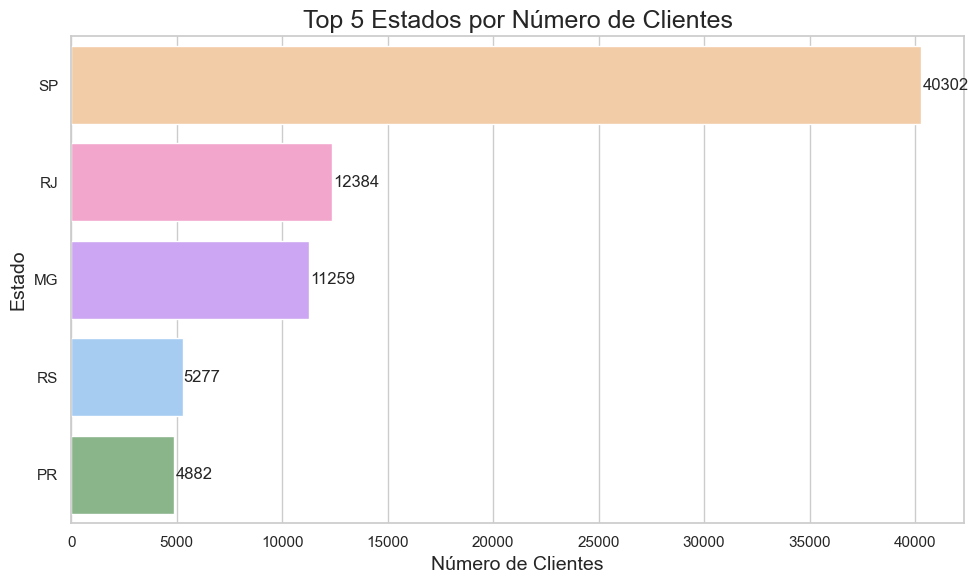

In [9]:
 #agrupo por estado y cuento clientes únicos
customer_by_state = df_olist_customers.groupby('customer_state')['customer_unique_id'].nunique().reset_index(name='num_customers')
customer_by_state = customer_by_state.sort_values('num_customers', ascending=False)
 
#seleccionar los 5 estados con mas clientes
top5_states = customer_by_state.head(5)
 
#configuro el estilo
sns.set(style="whitegrid")
 
#creo gráfico de barras horizontal
plt.figure(figsize=(10, 6))
colores_personalizados = ['#ffcc99', '#ff99cc', '#cc99ff', '#99ccff', '#83bb83']
sns.barplot(
    x='num_customers',
    y='customer_state',
    data=top5_states,
    palette=colores_personalizados
)
 
#añado ttitulo y etiquetas
plt.title('Top 5 Estados por Número de Clientes', fontsize=18)
plt.xlabel('Número de Clientes', fontsize=14)
plt.ylabel('Estado', fontsize=14)
 
#valores a las barras
for index, value in enumerate(top5_states['num_customers']):
    plt.text(value + 50, index, str(value), va='center')
 
plt.tight_layout()
plt.show()

In [10]:
# 2. Añade a la tabla anterior dos columnas (nº pedidos y el porcentaje respecto al total de pedidos), y el ratio del numero de pedido medio por cliente,
#  representa la información en el grafico que consideres oportuno ¿Que te transmite esta informacion? ¿Que acciones como analista de datos crees que deberia de tomar 
# la empresa para mejorar sus ventas? 

# Obtenemos el total de pedidos de nuestro DataFrame
total_orders = df_olist_orders['order_id'].count()

# Creamos un nuevo DataFrame para obtener los clientes de los 5 estados con más pedidos, de los cuales obtenemos su id
# su unique id y su estado.
customers_top_5_states  = df_top5_customers[['customer_id','customer_unique_id', 'customer_state']]

# Mezclamos el DataFrame anterior con el de pedidos para obtener los pedidos de esos clientes.
df_orders_top_5 = df_olist_orders.merge(customers_top_5_states, on='customer_id', how='inner')

# Obtenemos el total de pedidos de cada estado.
total_orders_states = df_orders_top_5.groupby('customer_state').size().reset_index(name='num_orders')

# Y en el DataFrame de estados agregamos el total de pedidos.
top5_states = top5_states.merge(total_orders_states, on='customer_state', how='inner')

# Obtenemos el porcentaje de pedidos de ese estado con respecto al total.
top5_states['%'] = (top5_states['num_orders']/total_orders) * 100

# Y hacemos lo mismo para el ratio de pedidos por cliente.
top5_states['Ratio'] = top5_states['num_orders']/top5_states['num_customers']

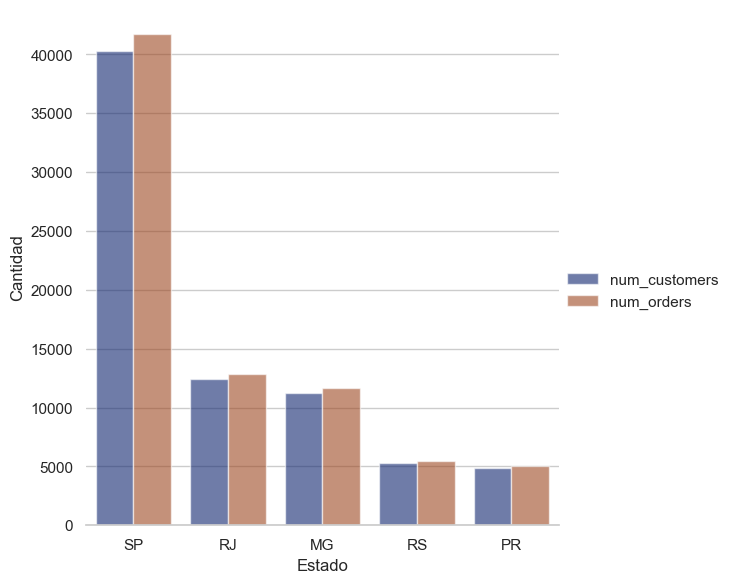

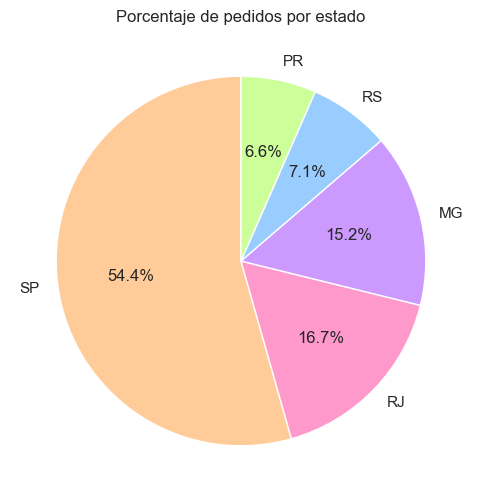

In [11]:
#convierto top5_states a formato largo
plot_df = top5_states.melt(
    id_vars='customer_state',    
    value_vars=['num_customers', 'num_orders'],
    var_name='metric',                      
    value_name='count'                      
)
 
#cambio el tema visual de Seaborn
sns.set_theme(style="whitegrid")
 
#creo un gráfico de barras agrupadas
g = sns.catplot(
    data=plot_df, kind="bar",
    x="customer_state", y="count", hue="metric",
    errorbar=None, palette="dark", alpha=.6, height=6
)
 
#ajusto detalles del gráfico
g.despine(left=True)                
g.set_axis_labels("Estado", "Cantidad")
g.legend.set_title("")              
 
#muestro el gráfico de barras
plt.show()
 
 
#creo un gráfico de tarta
plt.figure(figsize=(6, 6))  
plt.pie(
    top5_states['%'],                      
    labels=top5_states['customer_state'],  
    autopct='%1.1f%%',                      
    startangle=90,                        
    colors=['#ffcc99', '#ff99cc', '#cc99ff', '#99ccff', '#ccff99']
)
 
#título
plt.title('Porcentaje de pedidos por estado')
 
 
plt.show()

In [12]:
top5_states

,customer_state,num_customers,num_orders,%,Ratio
0,SP,40302,41746,41.980672,1.035829
1,RJ,12384,12852,12.924247,1.037791
2,MG,11259,11635,11.700405,1.033396
3,RS,5277,5466,5.496727,1.035816
4,PR,4882,5045,5.073360,1.033388


In [13]:
# 3. Calcula, el nº de pedidos que llegan tarde por ciudad, el porcentaje que representa respecto al total de pedidos por ciudad, junto
#  con el tiempo medio de dias que se pasan de fecha, queremos que a la hora de representar esta falla salga ya autodiagnosticada con la 
# razon mas probable del problema (Analiza el dataset)

# Primero preparamos un nuevo DataFrame que unicamente han sido entregados, para ello filtamos los pedidos cuyo estado es 'delivered', 
# la fecha de entrega no nula y lo mismo para la fecha de entrega estimada.
df_orders_delivered = df_orders_top_5_states_city[
    (df_orders_top_5_states_city['order_status'] == 'delivered') &
    (df_orders_top_5_states_city['order_delivered_customer_date'].notna()) &
    (df_orders_top_5_states_city['order_estimated_delivery_date'].notna())
].copy() 

# Agregamos a este nuevo DataFrame una columna de tipo booleano que nos indica que pedidos han sido entregados tarde, para ello comprobamos si la fecha de entrega 
# es mayor a la fecha de entrega estimada.
df_orders_delivered['delivered_late'] = (df_orders_top_5_states_city['order_delivered_customer_date'] > df_orders_top_5_states_city['order_estimated_delivery_date'])

# Obtenemos el total de dias de retraso en la entrega
df_orders_delivered['delay_days'] = (df_orders_delivered['order_delivered_customer_date'] - df_orders_delivered['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

# Y para aquellas filas que no han tenido retraso en la entrega las completamos con valor 0
df_orders_delivered['delay_days'] = df_orders_delivered['delay_days'].apply(lambda x: max(0, x))

# Redondeamos los valores en la columna de dias de retraso para tener valores enteros.
df_orders_delivered['delay_days'] = df_orders_delivered['delay_days'].round()

# Creamos un nuevo DataFrame que contiene el total de entregas, el total de entregas con retraso y la media de dias
# de entrega con retraso.
city_delay_orders = df_orders_delivered.groupby(['customer_city', 'customer_state']).agg(
    {
        'order_id' : 'count',
        'delivered_late' : 'sum',
        'delay_days' : 'mean'
    }
).reset_index()

# Renombramos las columnas para trabajar con datos mas claros
city_delay_orders.columns = ['city', 'state', 'orders_deliverd', 'late_orders', 'mean_late_days']

# Finalmente obtenemos el procentaje de dias que hay de retraso en cada entrega.
city_delay_orders['late_percentage'] = (
    city_delay_orders['late_orders'] / city_delay_orders['orders_deliverd'] * 100
).round(2)

In [14]:
city_delay_orders

,city,state,orders_deliverd,late_orders,mean_late_days,late_percentage
0,abadia dos dourados,MG,3,0,0.000,0.00
1,abaete,MG,12,1,0.250,8.33
2,abatia,PR,3,0,0.000,0.00
3,abre campo,MG,5,0,0.000,0.00
4,acaiaca,MG,2,0,0.000,0.00
...,...,...,...,...,...,...
2241,wenceslau braz,PR,2,0,0.000,0.00
2242,werneck,RJ,2,1,9.500,50.00
2243,xambre,PR,2,0,0.000,0.00
2244,xangri-la,RS,8,1,3.125,12.50


In [15]:
df_olist_customers.to_csv('df_olist_customers_unique.csv', index=False)

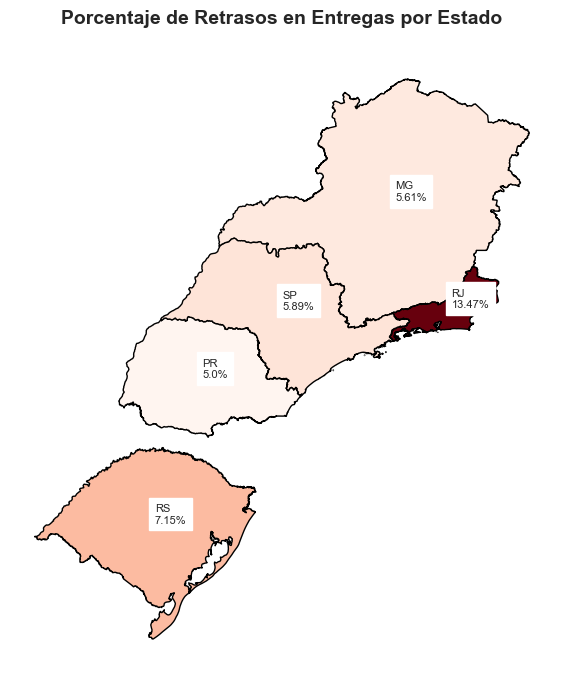

In [16]:
import geopandas as gpd

# Obtenemos lod datos anteiores de las ciudades con retraso, pero 
# esta vez lo agrupamos por estado
state_delays = city_delay_orders.groupby('state').agg({
    'orders_deliverd': 'sum',     
    'late_orders': 'sum',    
    'mean_late_days': 'mean'
}).reset_index()

# Obtenemos el porcentaje de retraso en la entrega de cada estado.
state_delays['late_percentage'] = (
    state_delays['late_orders'] / state_delays['orders_deliverd'] * 100
).round(2)

# Obtenemos de un repositorio de GitHub un fichero json con todas las coordeandas de los estados de brasil.
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brazil_states = gpd.read_file(url)

# Creamos un DataFrame en el cual mezclamos el DataFrame de los estados que hemos generado antes con el del mapa
# uniendolo mediante el valor state de nuestro DataFrame y el valor sigla del DataFrame del mapa. 
brazil_map = brazil_states.merge(
    state_delays,
    left_on='sigla',
    right_on='state',
    how='left'
)
#creamos la figura y la dimensionamos
fig, ax = plt.subplots(figsize=(12, 8))

#seleccionamos la columna y su paleta de colores a aplicar
brazil_map.plot(ax=ax, column='late_percentage', cmap='Reds', edgecolor='black',)

#creo un geodataframe y añado etiquetas para mostrar valores
for index, row in brazil_map.iterrows():
    if pd.notna(row['late_percentage']):
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, f"{row['sigla']}\n{row['late_percentage']}%", fontsize=8, bbox=dict(facecolor='white', linewidth=1))

#añado título y oculto la cuadrícula
ax.set_title('Porcentaje de Retrasos en Entregas por Estado', fontsize=14, fontweight='bold', pad=20)
ax.axis('off')

plt.show()


In [17]:
top5_states

,customer_state,num_customers,num_orders,%,Ratio
0,SP,40302,41746,41.980672,1.035829
1,RJ,12384,12852,12.924247,1.037791
2,MG,11259,11635,11.700405,1.033396
3,RS,5277,5466,5.496727,1.035816
4,PR,4882,5045,5.073360,1.033388


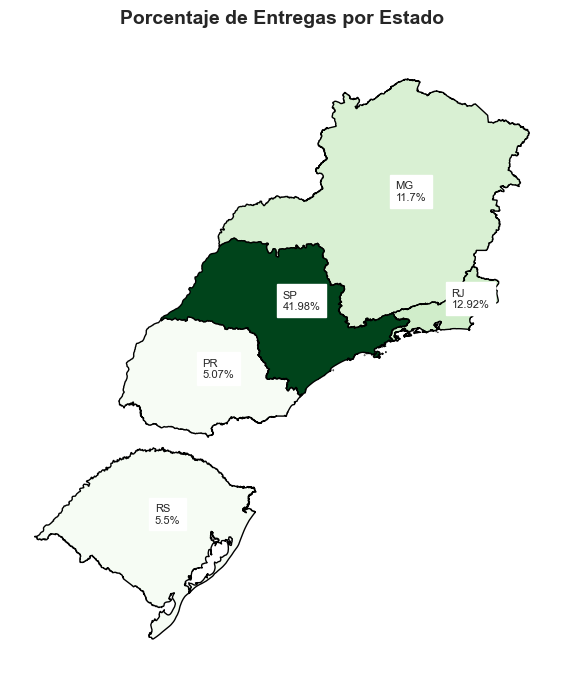

In [18]:
# Para representar en un mapa el % de envios que hay en cada estado con respecto al total usamos
# nuestro DataFrame de top5_states que hemos usado previamente para otro ejercicio
top5_states['%'] = top5_states['%'].round(2)
 
# Volvemos a mezclar como en el caso anterior
brazil_map_orders = brazil_states.merge(
    top5_states,
    left_on='sigla',
    right_on='customer_state',
    how='left'
)
#creamos la figura y la dimensionamos
fig, ax = plt.subplots(figsize=(12, 8))
 
#seleccionamos la columna y su paleta de colores a aplicar
brazil_map_orders.plot(ax=ax, column='%', cmap='Greens', edgecolor='black')
 
#creo un geodataframe y añado etiquetas para mostrar valores
for index, row in brazil_map_orders.iterrows():
    if pd.notna(row['%']):
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, f"{row['sigla']}\n{row['%']}%", fontsize=8, bbox=dict(facecolor='white', linewidth=1))
 
#añado título y oculto la cuadrícula
ax.set_title('Porcentaje de Entregas por Estado', fontsize=14, fontweight='bold', pad=20)
ax.axis('off')
 
plt.show()
 

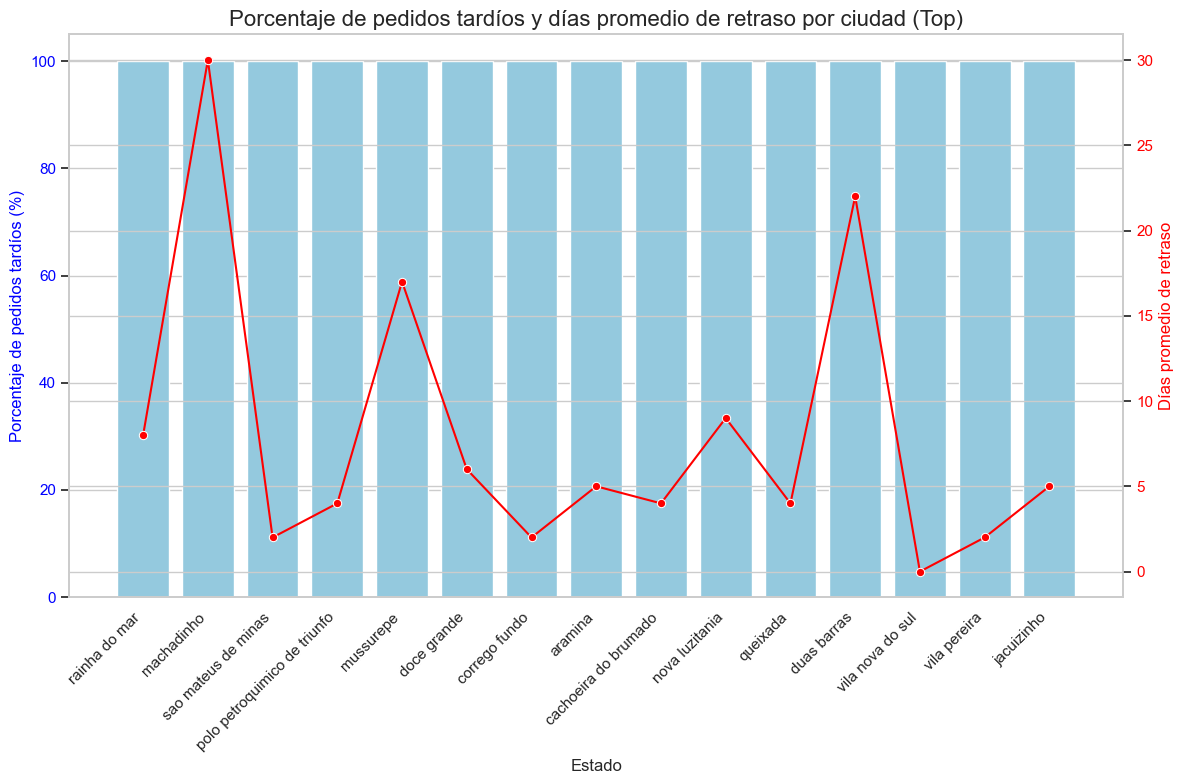

In [19]:
#ordeno las ciudades y selecciona las primeras 15
city_delay_orders_sorted = city_delay_orders.sort_values('late_percentage', ascending=False).head(15)
 
# Si quisiéramos las 15 primeras por orden alfabético, usaríamos:
# city_delay_orders_sorted = city_delay_orders.head(15)
 
#creo la figura y el primer eje (para el gráfico de barras)
fig, ax1 = plt.subplots(figsize=(12, 8))
 
#gráfico de barras
sns.barplot(
    data=city_delay_orders_sorted,
    x='city',
    y='late_percentage',
    ax=ax1,
    color='skyblue'
)
 
#configuro etiquetas y izquierdo
ax1.set_ylabel('Porcentaje de pedidos tardíos (%)', color='blue')
ax1.set_xlabel('Estado')  
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45, ha='right')  
 
#creo un segundo eje y
ax2 = ax1.twinx()
 
#gráfico de línea
sns.lineplot(
    data=city_delay_orders_sorted,
    x='city',
    y='mean_late_days',
    ax=ax2,
    color='red',
    marker='o'  
)
 
# configuro etiquetas del eje y derecho
ax2.set_ylabel('Días promedio de retraso', color='red')
ax2.tick_params(axis='y', labelcolor='red')
 
#título
plt.title('Porcentaje de pedidos tardíos y días promedio de retraso por ciudad (Top)', fontsize=16)
 
plt.tight_layout()

C:\Users\sorgaz\AppData\Local\Temp\ipykernel_25100\1364869854.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


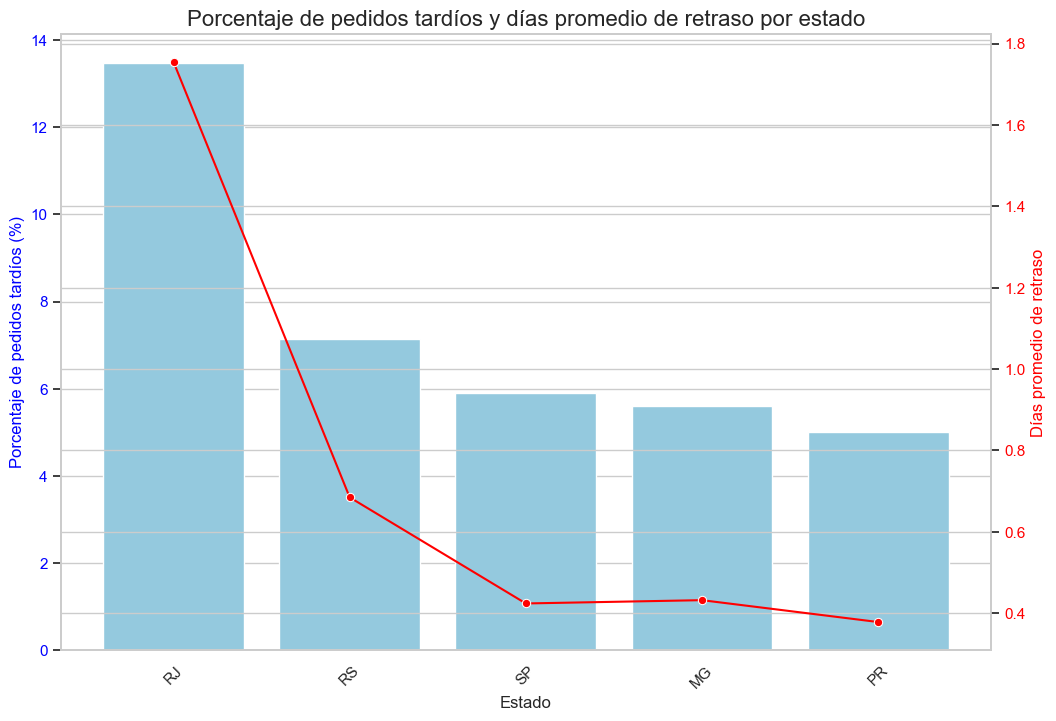

In [20]:
# agrupo por estado del cliente y calcula métricas
state_delay_orders = df_orders_delivered.groupby('customer_state').agg(
    orders_deliverd=('order_id', 'count'),    
    late_orders=('delivered_late', 'sum'),      
    mean_late_days=('delay_days', 'mean')      
).reset_index()  
 
#calculo el porcentaje de pedidos tardíos por estado
state_delay_orders['late_percentage'] = (
    state_delay_orders['late_orders'] / state_delay_orders['orders_deliverd'] * 100
).round(2)
 
#ordeno los estados por porcentaje de pedidos tardíos (de mayor a menor)
state_delay_orders_sorted = state_delay_orders.sort_values('late_percentage', ascending=False)
 
#creo la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(12, 8))
 
#gráfico de barras
sns.barplot(
    data=state_delay_orders_sorted,
    x='customer_state',
    y='late_percentage',
    ax=ax1,
    color='skyblue'
)
 
#etiquetas del eje y izquierdo
ax1.set_ylabel('Porcentaje de pedidos tardíos (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)  # Rota las etiquetas del eje X para mejor legibilidad
ax1.set_xlabel('Estado')
 
#etiquetas del eje y derecho
ax2 = ax1.twinx()
 
#gráfico de línea
sns.lineplot(
    data=state_delay_orders_sorted,
    x='customer_state',
    y='mean_late_days',
    ax=ax2,
    color='red',
    marker='o',
    ci=None  
)
 
#configuro etiquetas y colores del eje y derecho
ax2.set_ylabel('Días promedio de retraso', color='red')
ax2.tick_params(axis='y', labelcolor='red')
 
#titulo
plt.title('Porcentaje de pedidos tardíos y días promedio de retraso por estado', fontsize=16)
 
plt.show()

In [21]:
#4. Calcula y representa el numero de reviews por estado y el score medio en cada una de ellas, como ya hemos tenido en cuenta los pedidos con retraso en la seccion 
# anterior vamos a eliminar estos datos del apartado de score ya que se entiende que la opinion será negativa por la tardanza de llegada del producto.

# Creamos un DataFrame que contenga todas las entregas que se han entregado en fecha.
df_orders_delivered_on_time = df_orders_delivered[df_orders_delivered['delivered_late'] == False].copy()

# Una vez creados ese DataFrame lo mezclamos con el DataFrame de opiniones de los pedidos para ver que puntuación tiene cada uno.
df_orders_delivered_on_time = df_orders_delivered_on_time.merge(df_olist_order_reviews, on='order_id', how='inner')

# Agrupamos los resultados por estado, obteniendo el total de pedidos de cada estado y la nota media de cada uno
states_reviews = df_orders_delivered_on_time.groupby(['customer_state']).agg(
    {
        'order_id' : 'count',
        'review_score' : 'mean'
    }
).reset_index()

# Renombramos las columnas para poder trabajar mejor con los datos.
states_reviews.columns = ['state', 'num_reviews', 'mean_reviews']

In [22]:
df_orders_delivered_on_time.to_csv('df_orders_delivered_on_time.csv', index=False)

C:\Users\sorgaz\AppData\Local\Temp\ipykernel_25100\456878921.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


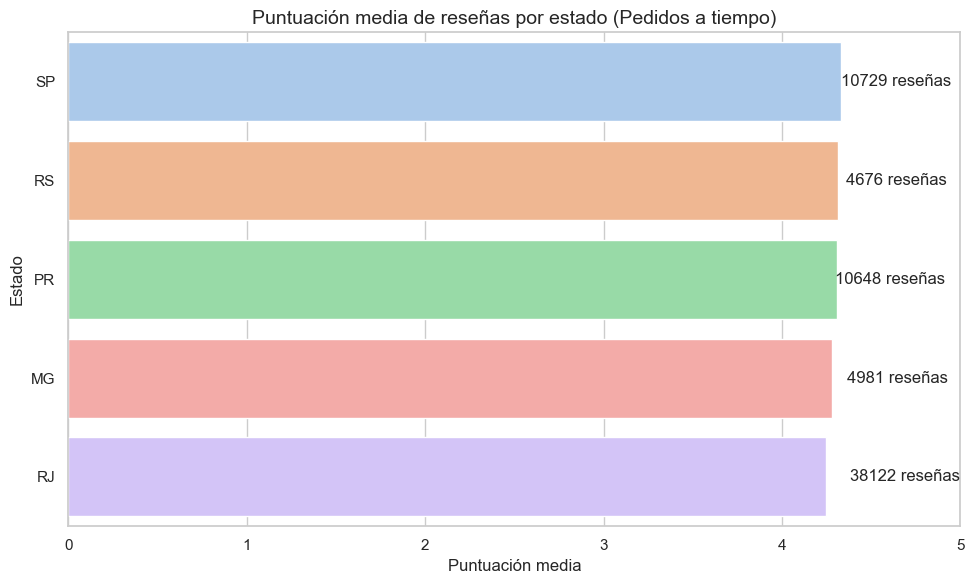

In [23]:
#ordenamos por puntuación media
states_reviews_sorted = states_reviews.sort_values('mean_reviews', ascending=False)
 
plt.figure(figsize=(10, 6))
sns.barplot(
    data=states_reviews_sorted,
    y='state',
    x='mean_reviews',
    palette='pastel'
)
 
#añadimos etiquetas
for index, row in states_reviews_sorted.iterrows():
    plt.text(row['mean_reviews'] + 0.05, index, f"{row['num_reviews']} reseñas", va='center')
 
#añadimos titulos y demás
plt.title('Puntuación media de reseñas por estado (Pedidos a tiempo)', fontsize=14)
plt.xlabel('Puntuación media')
plt.ylabel('Estado')
plt.xlim(0, 5)  
plt.tight_layout()
plt.show()

In [24]:
# Medida complementaria para el ejercicio anterior, obtener el total de puntuaciones de cada tipo/valor.

# Creamos un DataFrame que contenga el total de puntuaciones agrupadas por estado y tipo de puntuación.
states_reviews_count_scores = df_orders_delivered_on_time.groupby(['customer_state', 'review_score']).size().reset_index(name='count_scores')

# Invertimos la tabla para mostrar los datos en horizontal para verlos mas claros.
score_count = states_reviews_count_scores.pivot(
    index='customer_state', 
    columns='review_score', 
    values='count_scores'
).fillna(0)

# Converitimos los contados de puntuación a valor entero para poder ordenar los datos.
score_count = score_count.astype(int)
score_count = score_count.sort_values(by=5, ascending=False)

In [25]:
states_reviews_count_scores.to_csv('states_reviews_count_scores.csv', index=False)

<Figure size 1000x600 with 0 Axes>

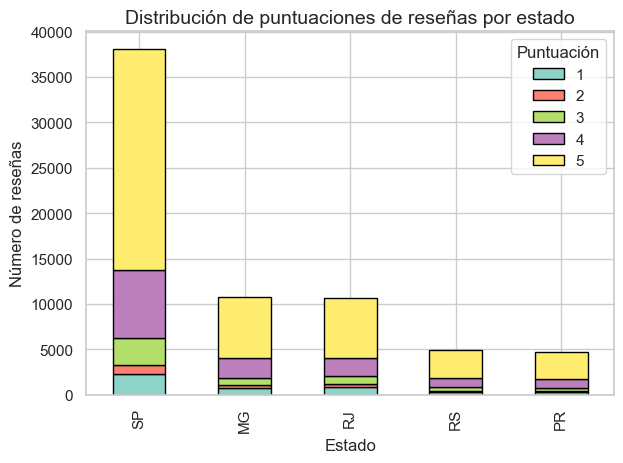

In [26]:
plt.figure(figsize=(10, 6))
 
#genero un grafico de barras apiladas
score_count.plot(kind='bar', stacked=True, colormap='Set3', edgecolor='black')
 
#añadimos titulos y demás
plt.title('Distribución de puntuaciones de reseñas por estado', fontsize=14)
plt.xlabel('Estado')
plt.ylabel('Número de reseñas')
plt.legend(title='Puntuación')
plt.tight_layout()
plt.show()

In [27]:
df_orders_delivered_payments = df_orders_delivered_on_time.merge(df_olist_order_payments, on='order_id', how='inner')

states_payments = df_orders_delivered_payments.groupby(['customer_state','payment_type']).agg(
    {
        'order_id' : 'count',
    }
).reset_index()

states_payments = states_payments.pivot(
    index='customer_state', 
    columns='payment_type', 
    values='order_id'
).fillna(0)

traducciones = {
    'boleto': 'Boleto',
    'credit_card': 'Tarjeta de Crédito',
    'debit_card': 'Tarjeta de Débito',
    'voucher': 'Cupón'
}

states_payments = states_payments.rename(columns=traducciones)

C:\Users\sorgaz\AppData\Local\Temp\ipykernel_25100\679392476.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


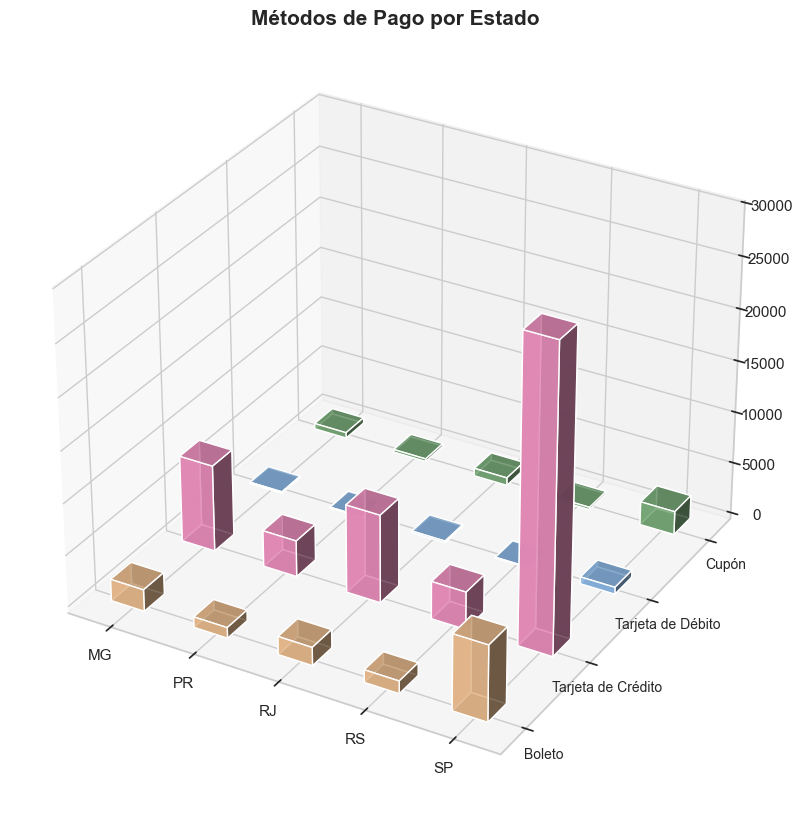

In [28]:
import numpy as np

#creamos la figura y la dimensionamos
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

#obtengo los datos
estados = states_payments.index.tolist()
payment_methods = states_payments.columns.tolist()

#colores
colors_payment = ['#ffcc99', '#ff99cc', '#99ccff', '#83bb83']

#posiciones
num_estados = len(estados)
num_payments = len(payment_methods)
x_pos = np.arange(num_estados)

#ancho y separacion
bar_width = 0.4
bar_depth = 0.7

#barras para cada metodo
for j, payment in enumerate(payment_methods):
    y_offset = j * 2.5
    values = states_payments[payment].values
    for i in range(num_estados):
        ax.bar3d(x_pos[i] - bar_width/2, y_offset, 0, bar_width, bar_depth, values[i], color=colors_payment[j], alpha=0.85)

#etiquetas de estados
ax.set_xticks(x_pos)
ax.set_xticklabels(estados, fontsize=11)

#metodos de pago alineados
y_ticks = [j * 2.5 + bar_depth/2 for j in range(num_payments)]
ax.set_yticks(y_ticks)
ax.set_yticklabels(payment_methods, fontsize=10)

#titulo
ax.set_title('Métodos de Pago por Estado', fontsize=15, weight='bold')

plt.tight_layout()
plt.show()